In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs

import random
import time

import functions_timescale as funcs

In [2]:
#### User input ####

## Minimal intensity to select region where high-velocity gas originates
min_intensity = 100. ## based on the PDR Toolbox, imposes a minimal FUV field of G0~10^3
min_intensity_out = 3*np.sqrt(50)*0.5 ## 50 spectral bins with an rms of ~0.5 K (3-sigma cut-off)

## age bins for histograms
age_bins = [0.05 + i*0.05 for i in range(0, 50)]

## maximum age of considered clusters
clus_cutoff = 2.5 ## Myr

## sample size
sample_size = [10000]#[10000, 30000, 50000]#10000

## Input to extract the M42 region of interest from the Orion A map
x1_M42 = 260
x2_M42 = 260+720
y1_M42 = 20
y2_M42 = 20+640


pc_in_cm = 3.09e18
Msun_in_gram = 2.0e33
H2_in_gram = 3.87e-24
H_in_gram = 2.2e-24


## Input for the studied regions
## Value list:
## 0: distance to the region
## 1: velocity weighted outflow velocity (in km/s which is basically pc/Myr)
## 2: cluster age in Myr
## 3: begin velocity blue wing
## 4: end velocity blue wing
## 5: begin velocity red wing
## 6: end velocity red wing
## 7: central velocity in the region
## 8: rms for the region
## -4: cloud mass
## -3: right ascension in hh:mm:ss or decimal form
## -2: declination in deg:mm:ss or decimal form
## -1: name of the region
names = {
    'W40_CII_final_20_8_0p5_clean': [502., 9.91, 0.9, -14., 1., 11., 23., 6., 0.5, 14900., '18:31:27.83', '-02:05:23.7', 'W40'],
    'RCW36_CII_final_20_8_0p5_clean': [950., 8.05, 1.1, -12., 1.65, 11.65, 22., 6.65, 0.9, 16200., '08:59:29.0', '-43:45:06.0', 'RCW 36'],
    'RCW120_CII_final_20_8_0p5_clean': [1680., 11.7, 1.2, -30., -12.5, -2.5, 18., -7.5, 0.5, 5450., '17:12:20.8', '-38:29:25.5', 'RCW 120'],
    #'OrionA_CII_final_20_8_0p5_clean': [414., '05:35:16.46', '-05:23:22.8', 'M42'],
    'NGC7538_CII_final_20_8_0p5_clean': [2650., 10.7, 2.2, -80., -61.2, -50.2, -33., -55.8, 0.8, 33300., '23:13:34.5', '61:30:14.3', 'NGC 7538'],
    'RCW79_CII_final_20_8_0p5_clean': [3900., 9.7, 2.3, -70., -52.2, -42.2, -26., -47.2, 0.6, 6300., '13:40:09.1', '-61:43:51.9', 'RCW 79'],
    'm16_CII_final_20_8_0p5_clean': [1706., 8.04, 1.3, 5., 16.8, 26.8, 41., 21.8, 0.5, 16700., 274.67, -13.78, 'M16'],
    'm17_CII_final_20_8_0p5_clean': [1900., 13.0, 0.58, -11., 12.9, 26.7, 52., 19.8, 0.5, 54600., 275.1, -16.16, 'M17'],
    #'RCW49_CII_final_20_8_0p5_clean': [4160., 12.2, '', '', 'RCW 49'], 
}

#####################

### support functions

In [3]:
## return all integrated intensity data
## Assumes that all data is at the same resolution and grid
def get_itg_int(name):
    ## total integrated intensity
    hdu = pyfits.open('../data_timescale/integrated/'+name+'_integrated.fits')
    data, header = hdu[0].data, hdu[0].header
    w = wcs.WCS(header)
    
    ## blue wing
    hdu = pyfits.open('../data_timescale/integrated/'+name+'_blue.fits')
    data_B = hdu[0].data
    
    ## red wing
    hdu = pyfits.open('../data_timescale/integrated/'+name+'_red.fits')
    data_R = hdu[0].data
    
    ## Remove all the unnecessary data from a map
    if(name == 'OrionA_CII_final_20_8_0p5_clean'):
        data = funcs.extract_region_in_map(data,x1_M42,x2_M42,y1_M42,y2_M42)
        data_B = funcs.extract_region_in_map(data_B,x1_M42,x2_M42,y1_M42,y2_M42)
        data_R = funcs.extract_region_in_map(data_R,x1_M42,x2_M42,y1_M42,y2_M42)
    
    return data, data_B, data_R, header, w
    

In [4]:
## get the data cube
def get_data_cube(name):
    hdu = pyfits.open('../data_timescale/'+name+'.fits')
    data, header = hdu[0].data, hdu[0].header
    
    if(name == 'OrionA_CII_final_20_8_0p5_clean'):
        data = funcs.extract_region_in_map(data,x1_M42,x2_M42,y1_M42,y2_M42)
    
    return data, header
    

In [5]:
## function that converts right ascencion and declination coordinates from hh/dd:mm:ss string format to decimal angle format
def WCStoDecimal(val1, val2):
    ## split the hh:mm:ss coordinates
    val1Res = val1.split(':')
    val2Res = val2.split(':')
    
    ## convert to the decimal format
    ra = float(val1Res[0]) * 15. + float(val1Res[1]) * 15. / 60. + float(val1Res[2]) * 15. / 3600.
    dec = float(val2Res[0]) + float(val2Res[1]) / 60. + float(val2Res[2]) / 3600.
    if(float(val2Res[0]) < 0.):
        dec = float(val2Res[0]) - float(val2Res[1]) / 60. - float(val2Res[2]) / 3600.
        
    return ra, dec

In [6]:
## Convert the velocity to a pixel index based on the provided header information
def vel_to_pixel(vel, crval, dv, crpix):
    return int((vel - crval)/dv + crpix + 0.5)

## Convert the pixel location to the velocity based on the provided header information
def pixel_to_vel(pix, crval, dv, crpix):
    return crval + dv*(pix - crpix)

In [7]:
## calculate weights as a function of distance in pixels
def weight_dist(r):
    return  1./(1. + r) 
    
## circumference of a circle is propto the radius (so use smoothed 1/r correction)

In [8]:
def create_velocity_array(min_vel, max_vel, dv):
    ## construct the velocity array using np.arange
    vel_arr = np.arange(start = min_vel, stop = max_vel, step = dv)
    
    return vel_arr

In [9]:
def factNCII(Tkin,n):
    #Rul = 3.8e-10 * (Tkin/100.)**0.14 ## for H_2
    Rul = 7.6e-10 * (Tkin/100.)**0.14 ## for H
    Cul = n*Rul
    val1 = 0.5*np.e**(91.25/Tkin)*(1.+2.4e-6 / Cul)
    val2 = (1.+val1)**(-1)
    val3 = 3.43e-16 * val2
    return val3

f1 = factNCII(50., 1e3)
f2 = factNCII(100., 1e3)
f3 = factNCII(250., 1e3)
print(f1)
print(f2)
print(f3)

2.3030441419668877e-17
5.552224683022035e-17
9.218154927437594e-17


### Perform the actual calculations

147.85764374030018
0.0024150943228587476
0.11622890811787435
0.0012721245181994596


/var/folders/pb/xs3f5mtd5bq7lmrql1dj8p040000gn/T/ipykernel_7580/200518722.py:81: RuntimeWarning: Mean of empty slice
  cplus_map = np.nanmean(cube_wings, axis = 0)*cube_wings.shape[0]*dv/f2 ## C+ column density


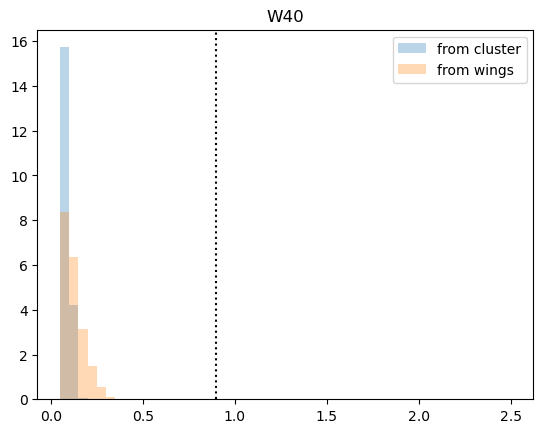

107.8991380001144
0.0017386295100271323
0.08821221185552015
0.0012231768791472863


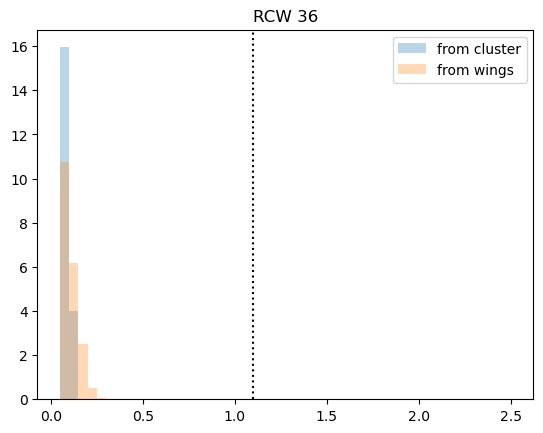

1251.3959405979322
0.007944255527479672
0.26175165727805194
0.0047808520244385965


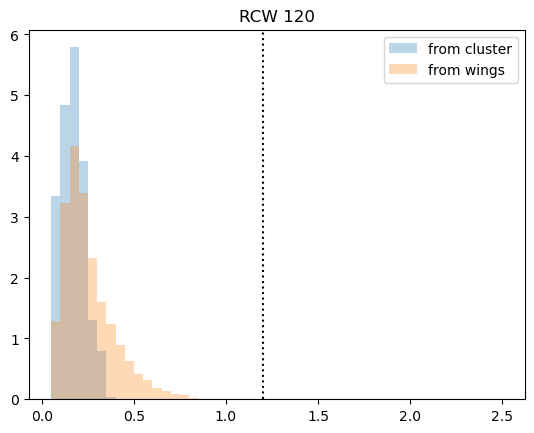

1832.2412501932283
0.008415003605917142
0.3017939071624145
0.006071167133295315


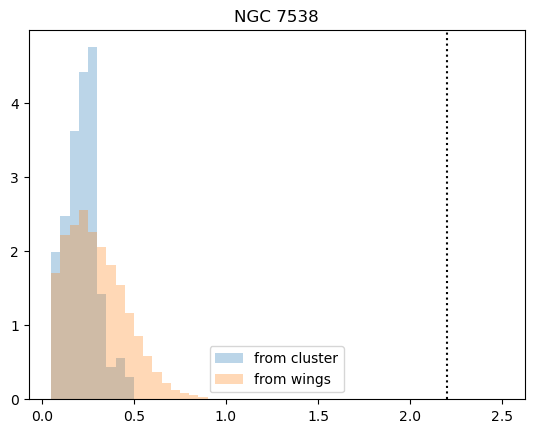

8818.050177488303
0.01950016377434924
0.6432175522643157
0.013709281014559014


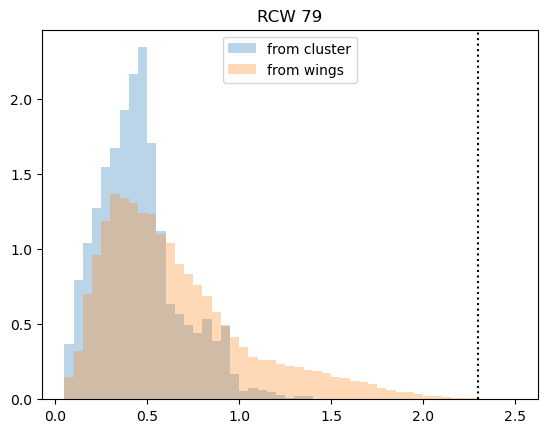

7774.552691273968
0.020227979489055598
0.4380546288179619
0.01774790672170882


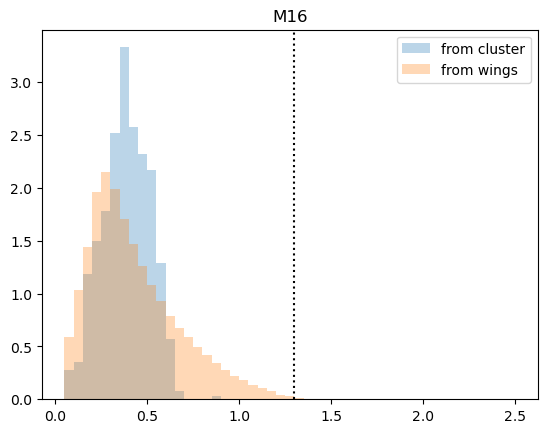

9292.544329696751
0.043043871931810015
0.21303220507176263
0.04362037339174347


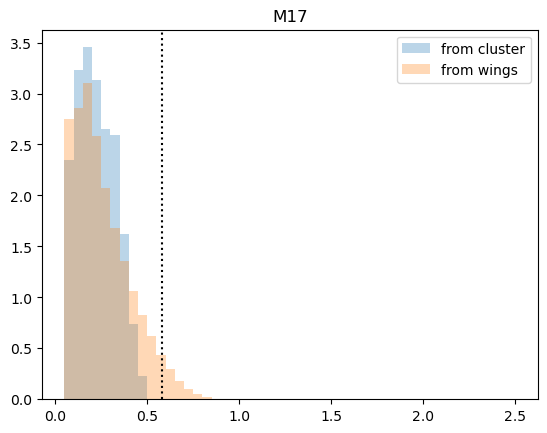

In [10]:
## lists to store results
dts_from_clus = []
dts_from_wings = []
rates_from_clus = []
rates_from_wings = []
times_from_clus, times_from_wings = [], []
tot_times_from_clus, tot_times_from_wings = [], []

name_list = []

## loop over all regions
for name in names:
    
    ## open the integrated intensity fits files and get the pixel size in pc
    data, data_B, data_R, header, w = get_itg_int(name)
    pix_size = names[name][0]*header['CDELT2']*np.pi/180.
    
    ## get the data cube (assumes that the data cube is on the same 2D spaxel grid as the integrated intensity map)
    cube, cube_header = get_data_cube(name)
    
    ## sum the wings together and set detection cut off + get the pixel indices of the detected outflowing gas
    data_out = data_B + data_R
    data_out[data_out < min_intensity_out] = np.nan
    inds_out = np.argwhere(~np.isnan(data_out))
    #print(inds_out)
    
    ## get the ra & dec of the cluster and ensure it is in decimal form
    ## then get the pixel coordinates of the cluster
    ra, dec = names[name][-3], names[name][-2]
    if(isinstance(ra, str)): ra, dec = WCStoDecimal(ra, dec)
    pix_clus = w.wcs_world2pix(np.array([[ra, dec]]), 1)
    pix_clus = pix_clus[0]
    
    ## calculate the distance from the cluster to the outflow
    diff_clus_pix = (inds_out - pix_clus)*pix_size
    diff_clus_pc = np.zeros(shape = diff_clus_pix.shape[0])
    for i, pix in enumerate(diff_clus_pix): diff_clus_pc[i] = np.sqrt(pix[0]**2 + pix[1]**2)
    
    ## convert the distance to timescale distribution based on the intensity weighted outflow velocity
    ## /np.sqrt(2): 2D -> 1D
    dt_clus = diff_clus_pc / names[name][1] / np.sqrt(2)
    dts_from_clus.append(np.nanmean(dt_clus))
    
    ## get the origin regions of the outflowing gas
    #inds_beg = np.argwhere(data > min_intensity)
    
    ## get the pixel locations for the high-velocity wings
    cv, dv, vpix = 0.001*cube_header['CRVAL3'], 0.001*cube_header['CDELT3'], cube_header['CRPIX3']
    vb1pix, vb2pix = vel_to_pixel(names[name][3], cv, dv, vpix), vel_to_pixel(names[name][4], cv, dv, vpix)
    vr1pix, vr2pix = vel_to_pixel(names[name][5], cv, dv, vpix), vel_to_pixel(names[name][6], cv, dv, vpix)
    
    ## create outflow velocity array relative to the cloud velocity
    cloud_vel = names[name][7]
    min_vel, max_vel = pixel_to_vel(0, cv, dv, vpix), pixel_to_vel(cube.shape[0], cv, dv, vpix)
    vel_arr = create_velocity_array(min_vel, max_vel, dv) - cloud_vel
    
    
    
    ## extract the wings from the data cube and set undected emission to nan
    cube_wings = np.append(cube[vb1pix:vb2pix, :, :], cube[vr1pix:vr2pix, :, :], axis = 0)
    vel_wings = np.append(vel_arr[vb1pix:vb2pix], vel_arr[vr1pix:vr2pix])
    wing_inds = np.argwhere(cube_wings > 3.*names[name][8])
    
    ## calculate the dt for each detected outflow component
    ## Also calculate the weight for each component based on their intensity
    dt_from_wings = np.zeros(shape = wing_inds.shape[0])
    w_for_wings = np.zeros(shape = wing_inds.shape[0])
    for i, pix in enumerate(wing_inds):
        d = np.sqrt((pix[1] - pix_clus[0])**2 + (pix[2] - pix_clus[1])**2)*pix_size
        dt_from_wings[i] = d/abs(vel_wings[pix[0]])/np.sqrt(2) ## /np.sqrt(2): 2D -> 1D
        w_for_wings[i] = cube_wings[pix[0], pix[1], pix[2]]
    dts_from_wings.append(np.nanmean(dt_from_wings))
    
    ## normalize the weights
    w_for_wings = w_for_wings/np.nansum(w_for_wings)
    
    
    #### calculate the mass ejection rate ####
    
    ## calculate the total outflow mass
    cplus_map = np.nanmean(cube_wings, axis = 0)*cube_wings.shape[0]*dv/f2 ## C+ column density
    tot_mass = np.nansum(cplus_map)*6.3e3*H_in_gram*(pix_size*pc_in_cm)**2 /Msun_in_gram
    print(tot_mass)
    
    ## calculate the rate
    mrate1 = tot_mass/np.nanmean(dt_clus)/1e6 ## /1e6 for Msun/year
    rates_from_clus.append(mrate1)
    print(mrate1)
    
    t_weighted = np.nansum(w_for_wings*dt_from_wings)/np.nansum(w_for_wings)
    print(t_weighted)
    mrate2 = tot_mass/t_weighted/1e6 ## /1e6 for Msun/year
    rates_from_wings.append(mrate2)
    print(mrate2)
    
    
    #### calculate the cloud lifetime ####
    
    ## current estimated lifetime
    times_from_clus.append(names[name][-4]/mrate1/1e6) 
    times_from_wings.append(names[name][-4]/mrate2/1e6) 
    
    ## include cluster age estimate
    tot_times_from_clus.append(names[name][-4]/mrate1/1e6 + names[name][2])
    tot_times_from_wings.append(names[name][-4]/mrate2/1e6 + names[name][2])
    
    ## store name
    name_list.append(names[name][-1])
    
    ## for verification
    #cube_wings = cube_wings[cube_wings > 3.*names[name][8]]
    
    
    
    ## Plot of the timescale distribution using the cluster as reference
    plt.title(names[name][-1])
    plt.hist(dt_clus, bins = age_bins, alpha = 0.3, label = 'from cluster', density = True)
    plt.hist(dt_from_wings, bins = age_bins, alpha = 0.3, label = 'from wings', density = True)
    #plt.hist(dts_beg_out)
    plt.axvline(x = names[name][2], linestyle = ':', color = 'k')
    plt.legend()
    plt.show()
    
    ## verification plots
    #plt.hist(diff_clus_pc)
    #plt.imshow(data_out)
    
    # STILL CONSIDER THE VELOCITY DISTRIBUTIONS
    
    # STILL REMOVE ORION FROM AROUND M42 CUBE
    
    

In [11]:
print(dts_from_clus)
dt_clus_max = np.max(dts_from_clus)
dt_wing_max = np.max(dts_from_wings)
print(dt_clus_max)
print(dt_wing_max)

## probability that all dt_clus < dt_clus_max
p_clus = (dt_clus_max/clus_cutoff)**(len(dts_from_clus))
print('{perc}%'.format(perc = 100.*p_clus))

p_clus = (dt_wing_max/clus_cutoff)**(len(dts_from_wings))
print('{perc}%'.format(perc = 100.*p_clus))

[0.061222306036180424, 0.062059879564813424, 0.15752211598296104, 0.21773505229455387, 0.4522039034917069, 0.3843464788700429, 0.21588541905379646]
0.4522039034917069
0.6552399721819115
0.0006335196466674111%
0.008496158812522095%


That all expanding bubbles would be younger than 0.6 Myr is a 4 sigma event. So either there is a strong unknown bias in the source selection or a single expanding bubble is not appropriate

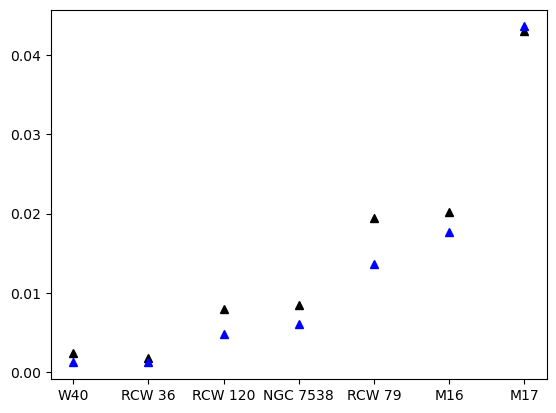

In [12]:
## mass ejection rates
plt.plot(name_list, rates_from_clus, 'k^')
plt.plot(name_list, rates_from_wings, 'b^')

plt.show()

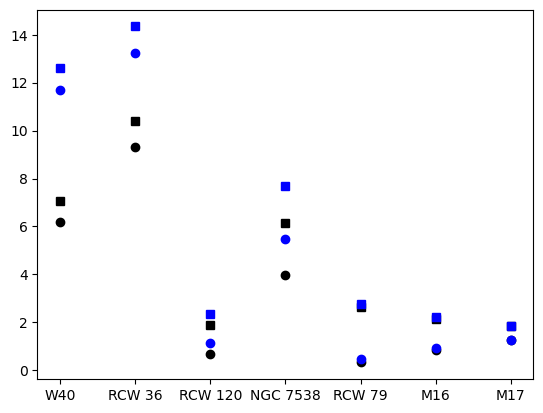

In [13]:
## current lifetime
plt.plot(name_list, times_from_clus, 'ko')
plt.plot(name_list, times_from_wings, 'bo')

## total cloud destruction timescale
plt.plot(name_list, tot_times_from_clus, 'ks')
plt.plot(name_list, tot_times_from_wings, 'bs')

plt.show()

In [14]:
'''
    ## random sample begin and end of the observed outflow
    start_time = time.time()
    
    ## Use random sampling to dermine the timescale
    for s_size in sample_size:
        ## get the random indices
        is_rand_beg1 = np.random.randint(low = 0, high = inds_beg.shape[0]-1, size = s_size)
        is_rand_out1 = np.random.randint(low = 0, high = inds_out.shape[0]-1, size = s_size)
        rand_vals = np.random.rand(s_size)
        
        ## Initialize numpy arrays to be used
        diff_beg_out = np.zeros(shape = s_size)
        diff_weights = np.zeros(shape = s_size)
        rand_out_vels = np.zeros(shape = s_size)
        #specs = np.zeros(shape = (s_size, vb2pix - vb1pix + vr2pix - vr1pix)) ## second array dimension: number of veloxity pixels
        
        ## loop over the randomly sampled pixel indices
        for i, (ib, io) in enumerate(zip(is_rand_beg1, is_rand_out1)):
            ## calculate the distance in pixel units
            dpix = inds_out[io] - inds_beg[ib]
            dpix2 = np.sqrt(dpix[0]**2 + dpix[1]**2)
            
            ## extract the local outflow spectrum + randomly sample & store the velocity
            temp_spec = np.append(cube[vb1pix:vb2pix, inds_out[io][0], inds_out[io][1]], cube[vr1pix:vr2pix, inds_out[io][0], inds_out[io][1]])
            temp_spec = np.cumsum(temp_spec)
            temp_spec = temp_spec/temp_spec[-1]
            rand_out_vels[i] = abs(pixel_to_vel(np.searchsorted(temp_spec, rand_vals[i]), cv, dv, vpix) - cloud_vel)
            
            ## store the distances in pc and associated probabilistic weights
            diff_beg_out[i] = dpix2*pix_size
            diff_weights[i] = weight_dist(dpix2)
        
        ## calculate the associated dynamical timescales
        dts_beg_out = diff_beg_out/names[name][1]
        
        ## calculate the dynamical sampling using random velocity sampling
        dts_beg_out_rand_v = diff_beg_out/rand_out_vels
        
        # CONTINUE HERE: PROBABLY STILL SOMETHING WRONG WITH RANDOM SAMPLING APPROACH: CHECK
        # PLOT: VEL AND DISTANCE DISTRIBUTIONS
        
        ## plot the dynamical timescales distribution
        plt.hist(dts_beg_out, bins = age_bins, alpha = 0.3, label = 'sample: {s}'.format(s = s_size), weights = diff_weights, density = True)
        plt.hist(dts_beg_out_rand_v, bins = age_bins, alpha = 0.3, weights = diff_weights, density = True)
    
    end_time = time.time()
    print(end_time - start_time)
    
    
    ## time the full loop
    
    # TOO SLOW: ~1S FOR 1M CALCS (100M+ CALCS PER MAP -> NEED RANDOM SAMPLING)
    
    #start_time = time.time()
    #diff_beg_out = np.zeros(shape = inds_beg.shape[0]*inds_out.shape[0])
    #j = 0
    #for pix_out in inds_out:
    #    for pix_beg in inds_beg:
    #        dpix = pix_out - pix_beg
    #        diff_beg_out[j] = np.sqrt(dpix[0]**2 + dpix[1]**2)
    #        j += 1
    #dts_beg_out = diff_beg_out/names[name][1]
    #end_time = time.time()
    #print(end_time - start_time)
    '''
    

"\n    ## random sample begin and end of the observed outflow\n    start_time = time.time()\n    \n    ## Use random sampling to dermine the timescale\n    for s_size in sample_size:\n        ## get the random indices\n        is_rand_beg1 = np.random.randint(low = 0, high = inds_beg.shape[0]-1, size = s_size)\n        is_rand_out1 = np.random.randint(low = 0, high = inds_out.shape[0]-1, size = s_size)\n        rand_vals = np.random.rand(s_size)\n        \n        ## Initialize numpy arrays to be used\n        diff_beg_out = np.zeros(shape = s_size)\n        diff_weights = np.zeros(shape = s_size)\n        rand_out_vels = np.zeros(shape = s_size)\n        #specs = np.zeros(shape = (s_size, vb2pix - vb1pix + vr2pix - vr1pix)) ## second array dimension: number of veloxity pixels\n        \n        ## loop over the randomly sampled pixel indices\n        for i, (ib, io) in enumerate(zip(is_rand_beg1, is_rand_out1)):\n            ## calculate the distance in pixel units\n            dpix =